In [4]:
import nltk
import gensim
import matplotlib.pyplot as plt
import numpy as np
import os
import re


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from wordcloud import WordCloud
from docx import Document


# Step 1: Read text files from local_data/papers

data_folder = r"C:/Users/Administrator/Desktop/MAN7916/local_data/papers"
text_files = sorted([os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.txt')])

corpus = []
for file in text_files:
    with open(file, "r", encoding="utf-8") as f:
        corpus.append(f.read())



In [5]:
# Step 2: Text preprocessing function
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    text = re.sub(r'[^A-Za-z]', ' ', text)  # Remove non-alphabet characters
    words = word_tokenize(text.lower())  # Convert to lowercase & tokenize
    words = [word for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords & short words
    return words

preprocessed_corpus = [preprocess(text) for text in corpus]


In [6]:
# Step 3: Train LDA models with different topic numbers and compute coherence scores

dictionary = corpora.Dictionary(preprocessed_corpus)
corpus_bow = [dictionary.doc2bow(text) for text in preprocessed_corpus]

coherence_scores = {}
models = {}

for k in range(2, 11):  # Train models with 2 to 10 topics
    lda_model = LdaModel(corpus=corpus_bow, id2word=dictionary, num_topics=k, passes=10)
    
    # Compute coherence score
    coherence_model = CoherenceModel(model=lda_model, texts=preprocessed_corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores[k] = coherence_score
    models[k] = lda_model

    print(f"Topics: {k}, Coherence Score: {coherence_score}")
    

Topics: 2, Coherence Score: 0.24094802220696457
Topics: 3, Coherence Score: 0.3273295864658573
Topics: 4, Coherence Score: 0.38496716504536405
Topics: 5, Coherence Score: 0.44299226785360624
Topics: 6, Coherence Score: 0.3988441816198834
Topics: 7, Coherence Score: 0.36922499750991505
Topics: 8, Coherence Score: 0.3892098276241591
Topics: 9, Coherence Score: 0.41384954825145837
Topics: 10, Coherence Score: 0.4140652194651344


Results saved to: C:\Users\Administrator\Desktop\MAN7916\assignments\submissions\assignment_5\topic_model_results.docx


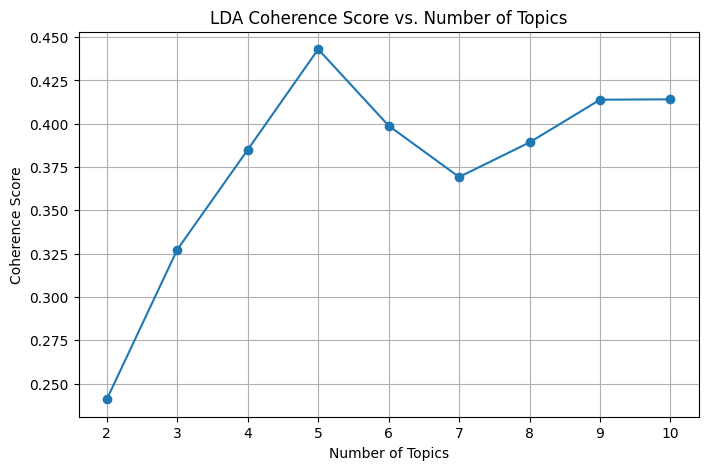

In [10]:

# Step 4: Save coherence scores to a document

doc = Document()
doc.add_heading('Topic Modeling Results', 0)

for k, score in coherence_scores.items():
    doc.add_paragraph(f"Topics: {k}, Coherence Score: {score}")
    
assignment_path = r"C:\Users\Administrator\Desktop\MAN7916\assignments\submissions\assignment_5"

result_path = os.path.join(assignment_path, "topic_model_results.docx")
doc.save(result_path)

print(f"Results saved to: {result_path}")
# Step 5: Plot coherence score curve and save the figure

plt.figure(figsize=(8, 5))
plt.plot(list(coherence_scores.keys()), list(coherence_scores.values()), marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("LDA Coherence Score vs. Number of Topics")
plt.grid()
plt.savefig("coherence_scores.jpg")
plt.show()

In [11]:
# Step 6: Select best topic number and fine-tune hyperparameters

best_k = max(coherence_scores, key=coherence_scores.get)  # Select best k
best_model = models[best_k]

best_coherence = coherence_scores[best_k]
best_params = (None, None)

for alpha in [0.01, 0.1, 0.5]:
    for eta in [0.01, 0.1, 0.5]:
        lda_model = LdaModel(corpus=corpus_bow, id2word=dictionary, num_topics=best_k, passes=10, alpha=alpha, eta=eta)
        coherence_model = CoherenceModel(model=lda_model, texts=preprocessed_corpus, dictionary=dictionary, coherence='c_v')
        score = coherence_model.get_coherence()
        
        if score > best_coherence:
            best_coherence = score
            best_model = lda_model
            best_params = (alpha, eta)

doc.add_paragraph(f"Best Coherence Score: {best_coherence}, Best Alpha: {best_params[0]}, Best Beta: {best_params[1]}")

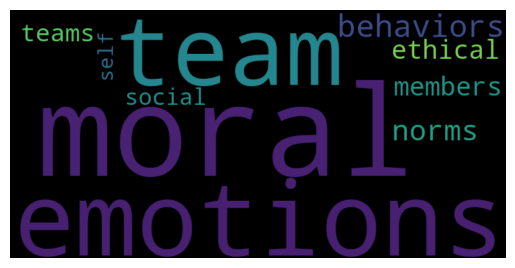

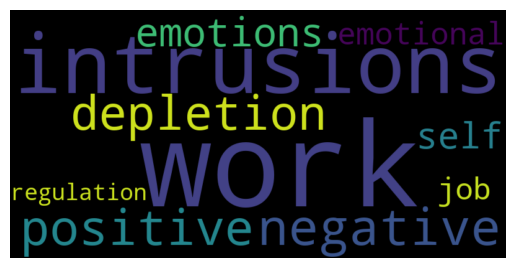

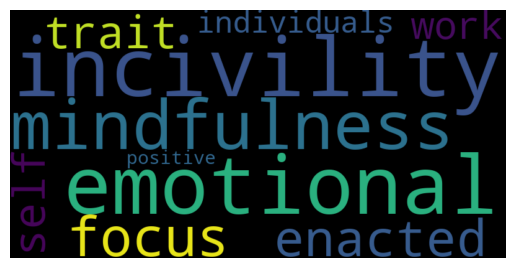

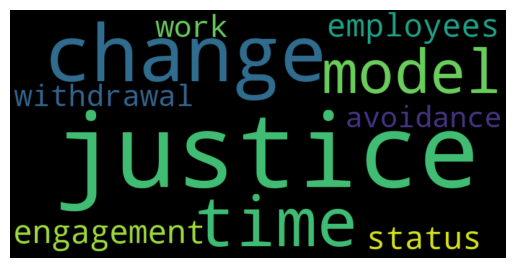

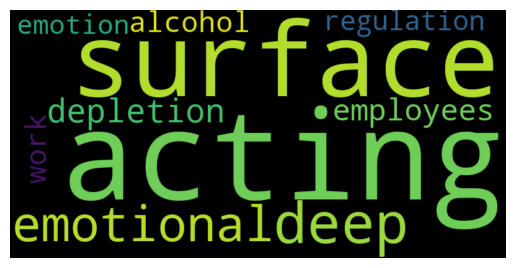

Results saved to: C:\Users\Administrator\Desktop\MAN7916\assignments\submissions\assignment_5\topic_model_results.docx
All tasks completed!


In [13]:
# step 7: Generate word clouds for best model topics

for i in range(best_k):
    words = dict(best_model.show_topic(i, 10))
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(words)
    wordcloud_path = os.path.join(assignment_path, f"topic_model_wordcloud_{i}.jpg")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(wordcloud_path)
    plt.show()

# Step 8: Infer topics for an unseen document

new_text = "Your new document content here..."  # Replace with new document text
new_preprocessed = preprocess(new_text)
new_bow_vector = dictionary.doc2bow(new_preprocessed)
topics = best_model.get_document_topics(new_bow_vector)

doc.add_paragraph("\nUnseen Article Topics:")
doc.add_paragraph(str(topics))

# Step 9: Save results to the assignment directory
doc_path = os.path.join(assignment_path, "topic_model_results.docx")
doc.save(doc_path)

print(f"Results saved to: {doc_path}")
print("All tasks completed!")
